# Accessibility-based characters

Linking points of interest and similar point-based data to enclosed tessellation using network accessibility approach.

For each enclosed tessellation cell, we want to know how many POIs are within 15 minutes walking distance (translated to 1200m). Furhtemore, we want to know how far is the closes one.

We use `pandana` package to generate accessibility characters. Pandana uses efficient [contraction hierarchies](https://en.wikipedia.org/wiki/Contraction_hierarchies) algorithm to measure the shortes path in a network. Therefore, we link each enclosed cell to a node of a network (the actual linking has been already done in [previous steps](morpohometrics)). Then we link each POI to a node of network and compute distances between nodes. Resulting values are then transferred from nodes back to tessellation. Note that all tessellation cells attached to a single node will share the same value.

In [7]:
import geopandas as gpd
import pandana
import pandas as pd
from shapely.geometry import box

## Create network

Load both parts of street network, i.e. nodes and edges (output of `momepy.nx_to_gdf`).

In [2]:
edges = gpd.read_parquet('../../urbangrammar_samba/spatial_signatures/morphometrics/edges/edges_0.pq')
nodes = gpd.read_parquet('../../urbangrammar_samba/spatial_signatures/morphometrics/nodes/nodes_0.pq')

Create `pandana.Network` object. We already have all necessary in our two GeoDataFrames.

In [3]:
nodes = nodes.set_index('nodeID')

In [4]:
%%time
network = pandana.Network(nodes.geometry.x, nodes.geometry.y, 
                          edges['node_start'], edges['node_end'], edges[['mm_len']])

CPU times: user 5.81 s, sys: 0 ns, total: 5.81 s
Wall time: 351 ms


## Find nearest POIs

Load points of interest, clip the to the extent of the chunk, link to `network` and find nearest to each network node.

In [5]:
pois = pd.read_csv('../../urbangrammar_samba/functional_data/pois/GEOLYTIX - RetailPoints/geolytix_retailpoints_v17_202008.csv')

In [8]:
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois.bng_e, pois.bng_n), crs=27700)
pois = gpd.clip(pois, box(*nodes.total_bounds))

In [9]:
%%time
network.set_pois(category = 'supermarkets',
                 maxdist = 1200,
                 maxitems=100,
                 x_col = pois.bng_e, 
                 y_col = pois.bng_n)

CPU times: user 12.8 ms, sys: 4.16 ms, total: 17 ms
Wall time: 14.8 ms


In [10]:
%%time
results = network.nearest_pois(distance = 1200,
                               category = 'supermarkets',
                               num_pois = 100,
                               include_poi_ids = False)

CPU times: user 3.01 s, sys: 120 ms, total: 3.13 s
Wall time: 2.68 s


We are interested in a distance to the nearest (if wihtin 15 minutes threshold) and number of POIs within the threshold.

In [11]:
counts = results.replace(1200, pd.NA).count(axis=1)

In [13]:
nodes['food'] = counts

<AxesSubplot:>

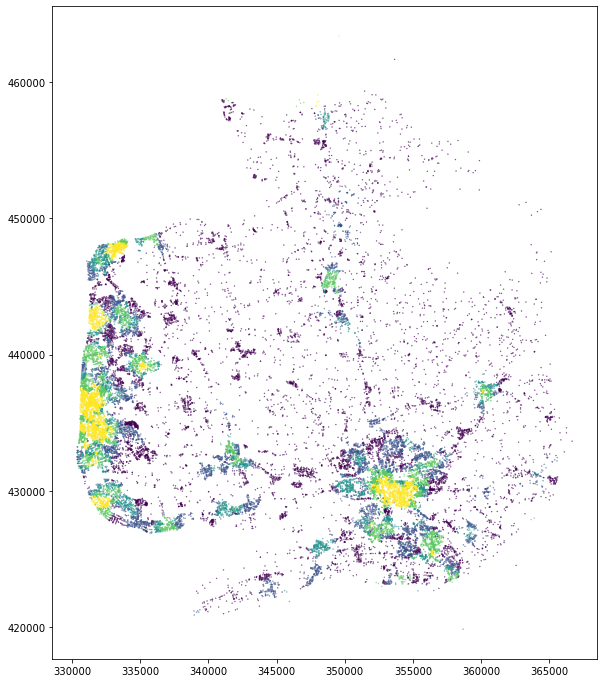

In [15]:
nodes.plot('food', figsize=(12, 12), markersize=(.1), scheme='quantiles')

In [18]:
min_distance = results.replace(1200, pd.NA).min(axis=1)

In [19]:
nodes['food_distance'] = min_distance

<AxesSubplot:>

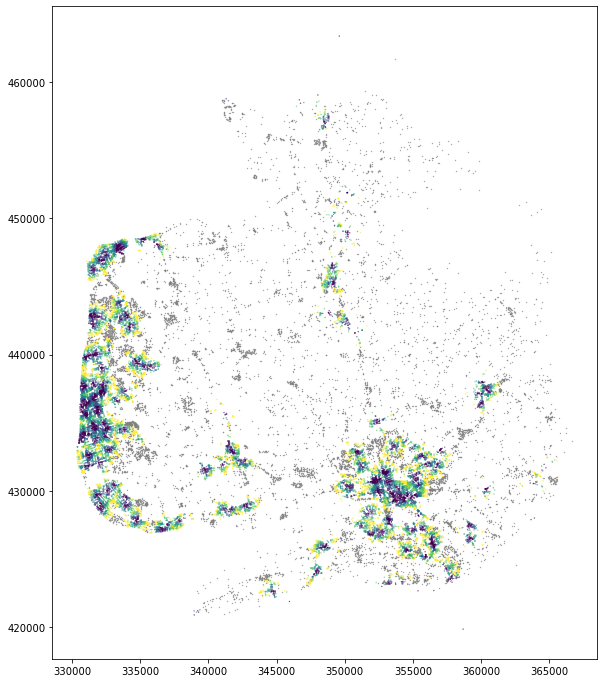

In [23]:
nodes.plot('food_distance', figsize=(12, 12), markersize=(.1), scheme='quantiles', missing_kwds={'color': 'grey', 'markersize': .1})